Stock market prediction is a challenging task. 
There are several unique challenges present in this domain that are not present in other common areas of machine learning such as Natural Language Processing, spam detection, computer vision and others. These challenges include:
* Swithing of regimes (non-stationarity)
* Reflexivity (market adaptation)
* Low signal-to-noise ration



## Content

* ## Regression Problem
* ### [Feature Engineering](#feature-eng)
* [Feature Selection](#feature-sel)
* [FeatureTools](#feature-tools)
* [Reduce Multicollinearity](#reduce-multicol)


Import all libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import technical_indicator as ti
import plotting as pl

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler,Normalizer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import datetime as dt


# Regression Problem

Data Management

**`features`**

Contains all features to be used for prediction. To avoid look-ahead bias, the dataframe only contains values that would have been known at that point in time. I'll explain about look-ahead bias later.

**`outcomes`**

Contains all possible outcomes to be predicted, conviniently shifted back in time. For example, if we wanted to predict the next day return, we would look ahead one day into the future, calculate the metric and record it at time T=0.

This makes it very easy to extract X and y for fitting models and join both dataframes as the rows are already aligned. 

Let's start from downloading the dataset. I used yfinance package to download prices.

Note: Set auto_adjust parameter to True so that the prices are adjusted for splits and dividends. 


In [2]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'SPY']
df = yf.download(tickers, period='10y', auto_adjust=True, group_by='ticker')
df.head(200)

[*********************100%***********************]  4 of 4 completed


MSFT                                                    SPY  \
                 Open       High        Low      Close    Volume        Open   
Date                                                                           
2011-03-30  20.427041  20.522792  20.347248  20.435020  41999300  108.742350   
2011-03-31  20.427046  20.490880  20.219584  20.259480  63233700  108.783366   
2011-04-01  20.371196  20.371196  20.195650  20.331299  63114200  109.447882   
2011-04-04  20.307352  20.474917  20.275434  20.387144  35433700  109.464271   
2011-04-05  20.602593  20.889849  20.538759  20.570677  73651100  109.111513   
...               ...        ...        ...        ...       ...         ...   
2012-01-06  22.418144  22.955593  22.418144  22.890448  99455500  106.915704   
2012-01-09  22.841583  22.882300  22.572859  22.589146  59706800  106.748919   
2012-01-10  22.743872  22.923022  22.597295  22.670584  60014400  107.908144   
2012-01-11  22.336710  22.784583  22.287851  22.572861  65582400  107.357710   
2012-01-12  22.695014  22.817161  22.515863  22.800875  49370800  108.058251   

                                                                AAPL  \
                  High         Low       Close     Volume       Open   
Date                                                                   
2011-03-30  109.242787  108.586474  108.922836  135835000  10.786730   
2011-03-31  109.078706  108.660300  108.775154  132537100  10.655063   
2011-04-01  109.743222  108.972056  109.234573  153850100  10.801189   
2011-04-04  109.661168  109.013068  109.324806  100768900  10.592002   
2011-04-05  109.792436  109.062292  109.308411  120791500  10.366819   
...                ...         ...         ...        ...        ...   
2012-01-06  106.932387  106.156789  106.507057  148050000  12.913377   
2012-01-09  106.899029  106.256876  106.765602   99530200  13.089651   
2012-01-10  108.124973  107.541192  107.691315  115282000  13.102258   
2012-01-11  107.891454  107.182582  107.749680  111540700  13.002897   
2012-01-12  108.166659  107.199244  108.008202  118983700  12.990590   

                                                              AMZN  \
                 High        Low      Close     Volume        Open   
Date                                                                 
2011-03-30  10.794114  10.688289  10.724896  329406000  177.779999   
2011-03-31  10.760888  10.645835  10.721204  274019200  179.309998   
2011-04-01  10.815955  10.560929  10.599690  418661600  181.580002   
2011-04-04  10.600923  10.410193  10.496021  460084800  180.889999   
2011-04-05  10.528632  10.336363  10.425268  482731200  182.100006   
...               ...        ...        ...        ...         ...   
2012-01-06  13.005051  12.896458  12.994284  318292800  178.070007   
2012-01-09  13.158867  12.961984  12.973674  394024400  182.759995   
2012-01-10  13.105027  12.966593  13.020121  258196400  181.100006   
2012-01-11  13.008128  12.899227  12.998899  215084800  179.639999   
2012-01-12  13.009663  12.881997  12.963211  212587200  179.419998   

                                                         
                  High         Low       Close   Volume  
Date                                                     
2011-03-30  181.160004  177.660004  179.419998  6859300  
2011-03-31  181.570007  178.500000  180.130005  4826500  
2011-04-01  183.250000  178.589996  180.130005  5684100  
2011-04-04  183.610001  180.690002  182.940002  4186400  
2011-04-05  186.360001  181.800003  185.289993  5569200  
...                ...         ...         ...      ...  
2012-01-06  184.649994  177.500000  182.610001  7008400  
2012-01-09  184.369995  177.000000  178.559998  5056900  
2012-01-10  182.399994  177.100006  179.339996  3985800  
2012-01-11  180.770004  178.190002  178.899994  3102700  
2012-01-12  179.490005  175.750000  175.929993  5385800  

[200 rows x 20 columns]

Visualising the datasets. I applied log function because Amazon stock were significantly higher, so it is impossible to visualise the prices of all three stocks

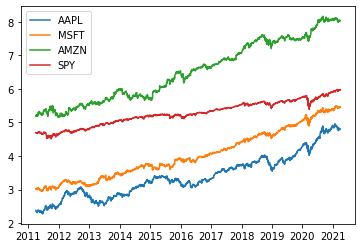

In [3]:
for ticker in tickers:
    plt.plot(df[ticker]['Close'].apply(np.log), label=ticker)
    
plt.legend()
    


# Feature Engineering <a name="feature-eng"></a>

Feature Engineering refers to pre-processing of raw data into a format which is more easily understood by machine learning algorithms. 

I believe it is one of the most important and underappreciated activities in machine learning. 

**Important considerations**

Since we are dealing with time-series data, it is crucial to be aware of potential challenges and biases we may introduce, whether intentially or unintentially.

**`Look-ahead bias`**

Look-ahead bias occurs when the information or data that is not available in the analysis period is used for a simulation. This can lead to innacurate results which are often overoptimistic. 

**`False ordinality`**

We should also avoid representing features in ordinal way if it has no meaning. For example, it is not the best approach to represent day of a week as an integer from 1 to 7 because we will be telling the model to treat one day differently than the other.



### Features to be considered:
`1`. Moving Averages

We'll be using moving averages (both simple and exponential) to construct other features.

`2`. Daily return

Percent change between closing price and opening price

`3`. Log volume

Volume transformed to log scale.

`4`. Price difference
Difference between today's and yesterday's closing price

`5`. Relative Strength Index
Measures the magnitude of recent price changes. Commonly used in technical analysis to evaluate overbought or oversold conditions in the price of a stock.
This indicator was developed by J.Welles Wilder Jr.
According to this indicator, a stock is considered overbought when the RSI is above 70% and oversold when it is below 30%.

`6`. Stochastic Oscillator

The Stochastic Oscillator is a momentum indicator that compares a specific closing price of a security to its high-low range over a certain period of time. First developed in the 1950s, it is a popular momentum indicator to identify overbought and oversold conditions of an asset. 

`7`. Moving Average Convergence Divergence (MACD)
MACD is a trend-following momentum indicator that demonstrates the relationship between two moving averages - long-term and short-term. MACD is calculated as 

MACD = EMA(26-period) - EMA(12-period)

MACD is often used together with Relative Strength (RSI) to show a more complete picture of a market.

The signal line is a 9-day EMA of the MACD Line. As a moving average of the indicator, it trails the MACD and makes it easier to spot MACD turns.


`8`. Average True Range(ATR)
ATR is a market volatility indicator. Introduced by market technician J.Welles Wilder Jr., this indicator measures market volatility by decomposing the complete range of a security price for that period.


`9`. Accumulation/Distribution Indicator (A/D)
The accumulation/distribution indicator (A/D) is a cumulative indicator that makes us of price and volume to assess whether an asset is being accumulated or distributed.

`10`. Money Flow Index
The Money Flow Index (MFI) is a technical oscillator that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100.



### Target variable

We will be prediciting the next day's closing price.


In [4]:
feature_names = ['daily_return', 'price_diff', 'vol_log']
col_names = pd.MultiIndex.from_product([tickers, feature_names])
features = pd.DataFrame(index=df.index, columns=col_names).sort_index()

for ticker in tickers:
    features.loc[:, (ticker, 'daily_return')] = df[ticker]['Close'] / df[ticker]['Open'] - 1
    features.loc[:, (ticker, 'price_diff')] = df[ticker]['Close'].diff(1)
    features.loc[:, (ticker, 'vol_log')] = df[ticker]['Volume'].apply(np.log)
    features.loc[:, (ticker, 'vol_diff_1')] = df[ticker]['Volume'].diff(1)
    features.loc[:, (ticker, 'vol_diff_50')] = df[ticker]['Volume'].diff(50)
    
    # Rate of change in volume
    features.loc[:, (ticker, 'roc_vol')] = ti.rate_of_change(df[ticker]['Volume'])
    
    for period in [5, 10, 20, 50, 100, 200]:
        
        # Moving average of volume (log)
        features.loc[:, (ticker, 'sma{}_vol'.format(period))] = ti.simple_ma(features[ticker]['vol_log'], period=period)
        
        # Closing price vs n-day EMA 
        features.loc[:, (ticker, 'close_vs_ema{}'.format(period))] = df[ticker]['Close'] / ti.exp_ma(df[ticker]['Close'], period=period) - 1
         
        # Daily Volume vs. n-day SMA
        features.loc[:, (ticker, 'vol_vs_sma{}'.format(period))] = df[ticker]['Volume'] / ti.simple_ma(df[ticker]['Volume'], period=period) - 1
    
    # Average True Range (14-day)
    features.loc[:, (ticker, 'atr')] = ti.average_true_range(df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'])
    
    # High divided by Average True Range with window of 10
    features.loc[:, (ticker, 'high10atr')] = df[ticker]['High'] / ti.average_true_range(df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'], period=10)
       
    # Relative Strengh Index (RSI)
    features.loc[:, (ticker, 'RSI')] = ti.RSI(df[ticker]['Close'])
    
    # Money Flow Index (MFI)
    features.loc[:, (ticker, 'MFI')] = ti.money_flow_index(df[ticker]['Volume'], df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'])

    # Stochastic Oscillator
    features.loc[:, (ticker, 'STOCH')] = ti.stochastic_oscillator(df[ticker]['Close'], df[ticker]['High'], df[ticker]['Low'])
    
    # Moving Average Convergence Divergence (MACD)
    features.loc[:, (ticker, 'MACD')] = ti.MACD(df[ticker]['Close']).iloc[:, 0]
    features.loc[:, (ticker, 'MACD_signal')] = ti.MACD(df[ticker]['Close']).iloc[:, 1]

    # Accumulation/Distribution
    features.loc[:, (ticker, 'ADI')] = ti.accumulation_distribution(df[ticker]['Close'], df[ticker]['Low'], df[ticker]['High'], df[ticker]['Volume'])

outcome_names = ['target_close_1']
col_names_out = pd.MultiIndex.from_product([tickers, outcome_names])
outcomes = pd.DataFrame(index=df.index, columns=col_names_out).sort_index()

for ticker in tickers:
    # Change in closing price in the next day
    outcomes.loc[:, (ticker, 'target_close_1')] = df[ticker]['Close'].pct_change(-1)

In [5]:
df_new = features.join(outcomes)
df_new = df_new.dropna()

## Feature Selection <a name="feature-sel"></a>


### Normalizing data

Before diving into evaluation of the features for predictive strength, we will standardize data given that we have data of different scales.

For that, we can use StandardScaler() method as part of scikit-learn package.

In [6]:
standard_scaler = StandardScaler()
df_scaled = standard_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, index=df.index)
df_scaled.columns = df.columns


<AxesSubplot:title={'center':'Strength of Correlation'}>

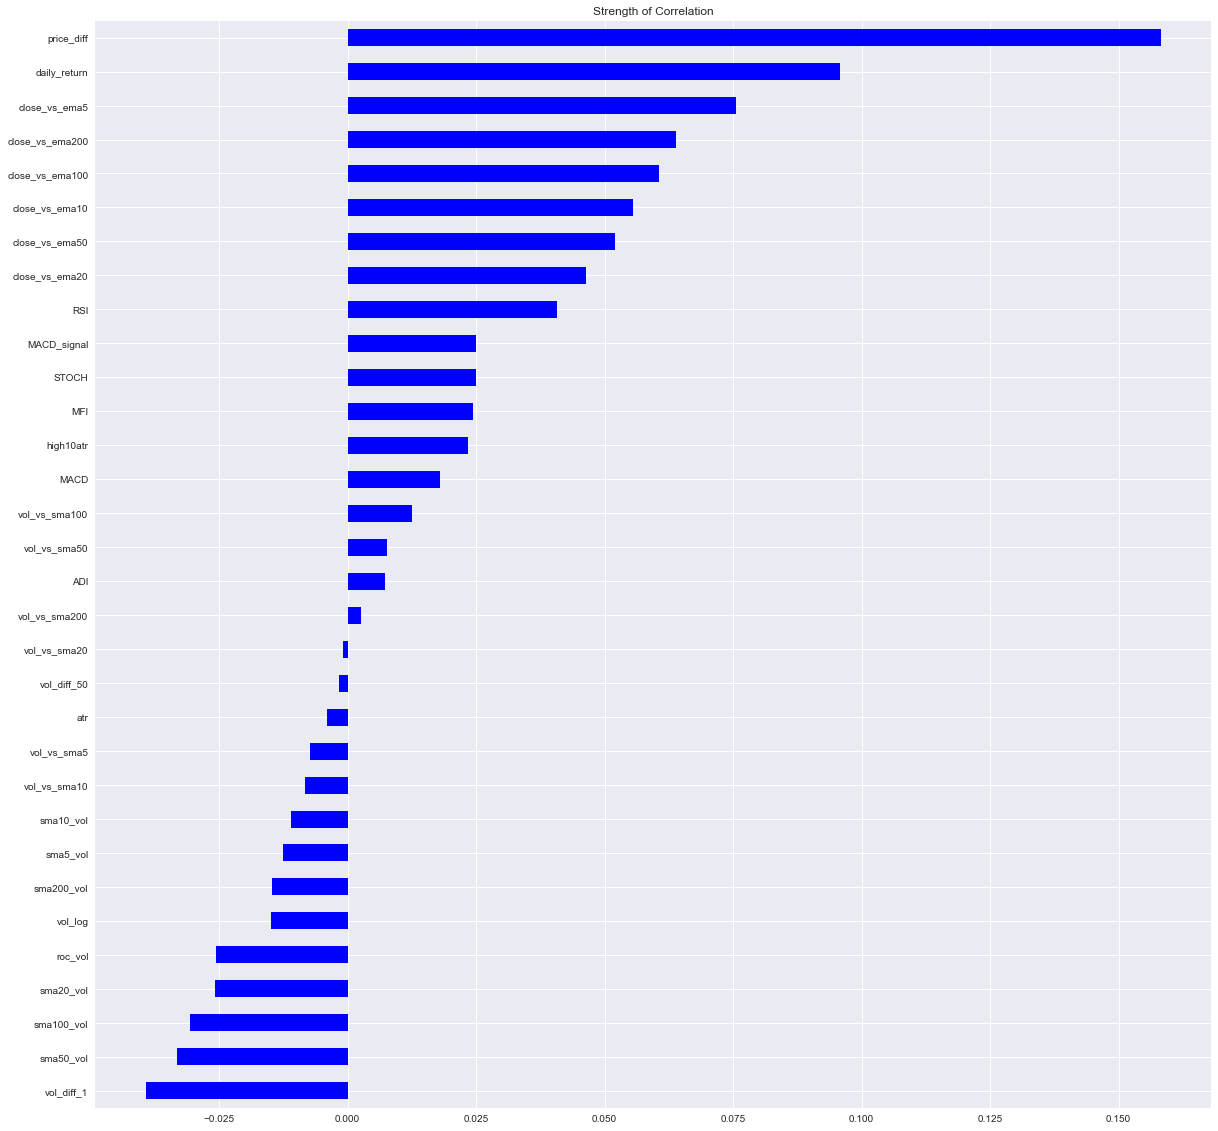

In [7]:
# Correlation strength
plt.style.use('seaborn')
plt.figure(figsize=(20,20))

corr = features['SPY'].corrwith(df_new['SPY']['target_close_1'])
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')


Even though correlation is not the ideal metric, it should give us an idea of strengh of each feature's relationship to the target variable.

However, it gives us no information about multicollinearity. 

We can leverage seaborn's clustermap chart that plots a heatmap representation of a covariance matrix.

It is important to note that scaling the features before runtime is a form of data leakage (I mentioned look-ahead bias earlier). However, for the purpose of EDA and to understand better the feature set, it can be justified.
Of course, we will not be using these scaled features when it comes to model training and testing as this would not have been available at that time.



In [8]:
feats_max_corr = corr[corr > 0.02].index
corr.sort_values(ascending=False)

price_diff         0.158197
daily_return       0.095857
close_vs_ema5      0.075652
close_vs_ema200    0.063821
close_vs_ema100    0.060514
close_vs_ema10     0.055536
close_vs_ema50     0.052024
close_vs_ema20     0.046419
RSI                0.040709
MACD_signal        0.025033
STOCH              0.025024
MFI                0.024304
high10atr          0.023363
MACD               0.017920
vol_vs_sma100      0.012503
vol_vs_sma50       0.007750
ADI                0.007193
vol_vs_sma200      0.002568
vol_vs_sma20      -0.000976
vol_diff_50       -0.001631
atr               -0.004087
vol_vs_sma5       -0.007261
vol_vs_sma10      -0.008289
sma10_vol         -0.010959
sma5_vol          -0.012569
sma200_vol        -0.014632
vol_log           -0.014833
roc_vol           -0.025512
sma20_vol         -0.025805
sma100_vol        -0.030603
sma50_vol         -0.033125
vol_diff_1        -0.039191
dtype: float64

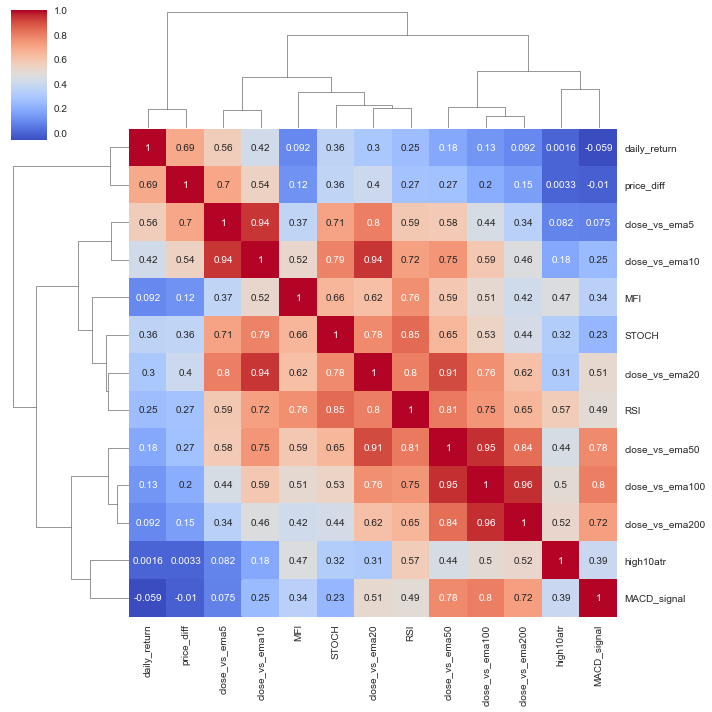

In [9]:
sns.clustermap(features['SPY'][feats_max_corr].corr(), cmap='coolwarm', annot=True, method='ward')

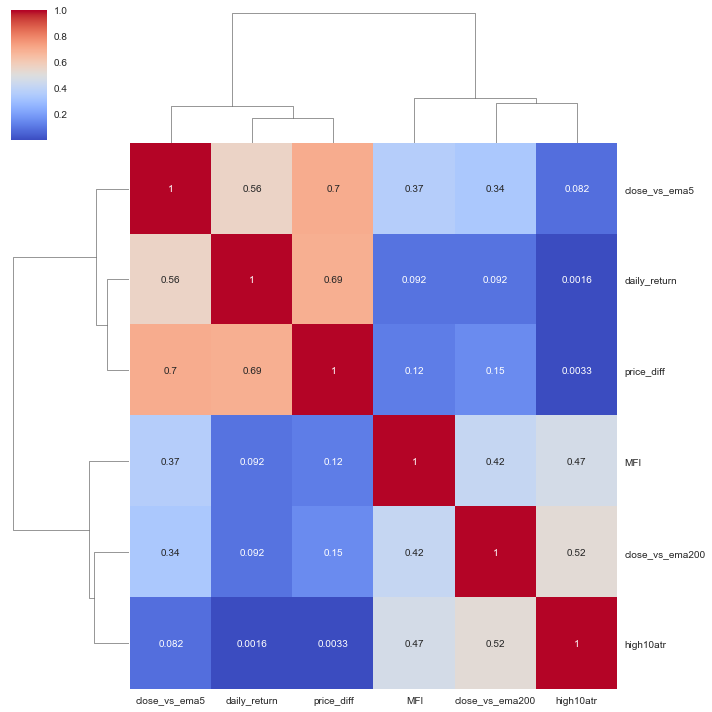

In [10]:
feats_selected = feats_max_corr.drop(['close_vs_ema10', 'close_vs_ema100', 
                                      'close_vs_ema20', 'RSI', 'close_vs_ema50', 
                                      'MACD_signal', 'STOCH'])
sns.clustermap(features['SPY'][feats_selected].corr(), cmap='coolwarm', annot=True, method='ward')


In [11]:
features_selected = df_new['SPY'][feats_selected]
df_SPY = df_new['SPY'].loc[:, features_selected.columns]

df_SPY = df_SPY.join(df_new['SPY']['target_close_1'])
df_SPY

,daily_return,price_diff,close_vs_ema5,close_vs_ema200,high10atr,MFI,target_close_1
Date,,,,,,,
2012-01-12,-0.000463,0.258522,0.005479,0.049089,97.008489,79.245765,0.005200
2012-01-13,0.001555,-0.558762,0.000185,0.043139,93.923072,69.834158,-0.003866
2012-01-17,-0.005689,0.416977,0.002707,0.046620,90.563113,70.546197,-0.010935
2012-01-18,0.011291,1.192604,0.009153,0.057487,98.598702,71.803731,-0.005249
2012-01-19,0.001829,0.575462,0.009606,0.062301,101.441996,78.085839,-0.003713
...,...,...,...,...,...,...,...
2021-03-22,0.006564,3.109985,0.001996,0.112398,80.228177,54.026588,0.007933
2021-03-23,-0.006149,-3.089996,-0.003935,0.102505,85.992079,55.001468,0.005109
2021-03-24,-0.008900,-1.980011,-0.006017,0.095844,83.886563,58.167518,-0.005594


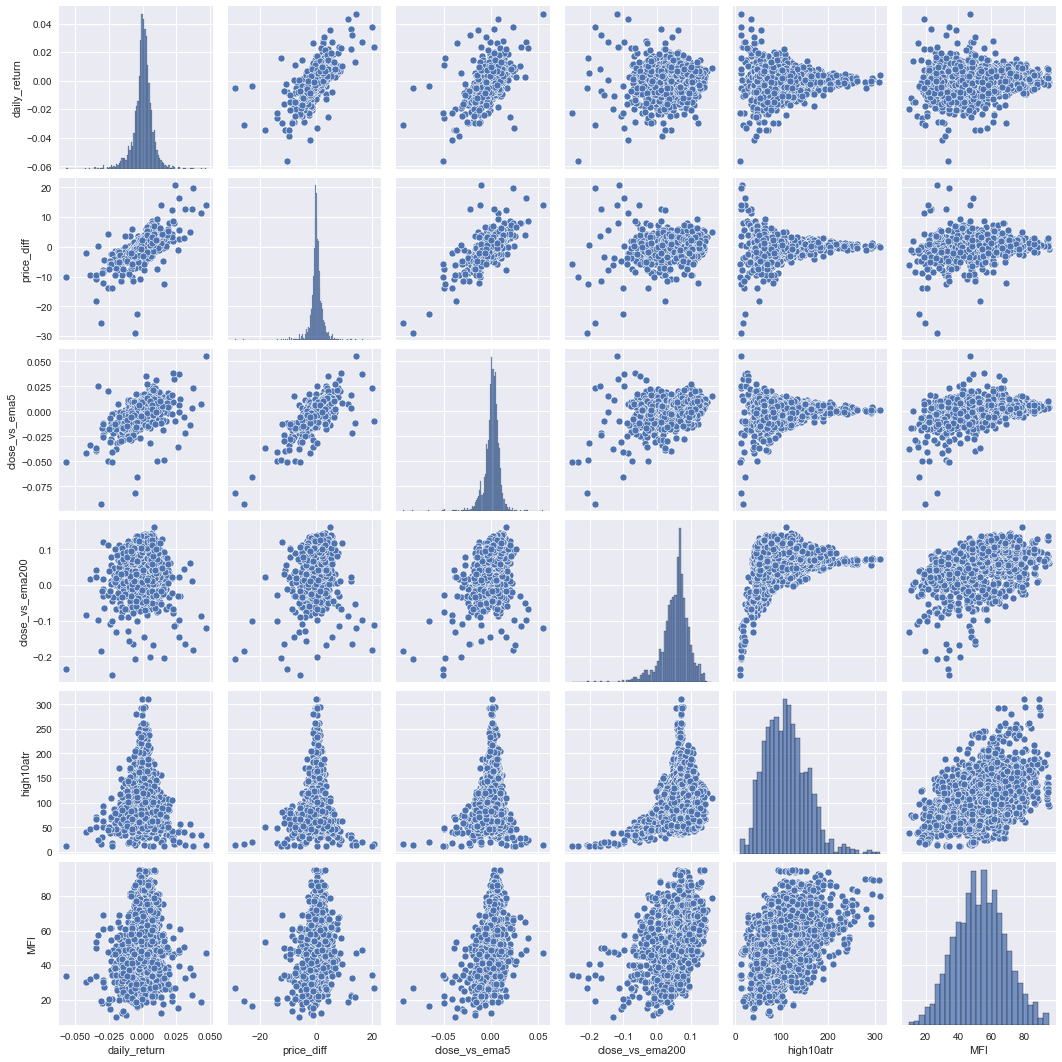

In [12]:
sns.pairplot(features_selected)

There is still some residual covariance, but we're close.


I have only used a simple correlation statistic on a full range of data thus far, but we shouldn't stop here.

Given that we're working with financial time series which is non-stationary and subject to constant regime change, the relationship that has been in place on average may be very unstable over time.

Below I'm plotting the rolling correlation of the selected features

<AxesSubplot:title={'center':'Correlation of features with target (by month)'}, xlabel='Date'>

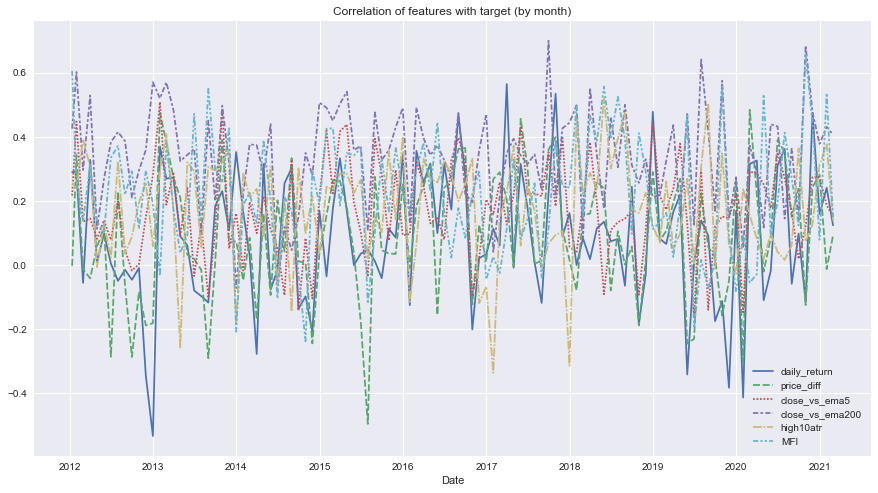

In [13]:
recalc_dates = df_SPY.resample('M').mean().index # Resample by month
recalc_dates = recalc_dates.insert(item=min(df_SPY.index), loc=0) # Add starting date
corrs = pd.DataFrame(index=recalc_dates, columns=features_selected.columns)
for i, date in enumerate(recalc_dates):
    try:
#         print("Calculating from {} to {}".format(recalc_dates[i], recalc_dates[i+1]))
        corr = features_selected.loc[recalc_dates[i]:recalc_dates[i+1]].corrwith(df_SPY.loc[recalc_dates[i]:recalc_dates[i+1]]['target_close_1'])
        corrs.loc[date, :] = corr

    except:
        break

corrs = corrs.dropna()
corrs = corrs.apply(lambda x: x.astype(float))

plt.figure(figsize=(15,8))
plt.title('Correlation of features with target (by month)')
sns.lineplot(data=corrs)


In [14]:
np.array(corrs['daily_return']).astype(float)

array([ 0.28911146,  0.29133108, -0.05657746,  0.32781112,  0.00702198,
        0.09809481,  0.00358218, -0.05025953, -0.01587274, -0.04689121,
       -0.00999335, -0.34572128, -0.53489575,  0.36916787,  0.26903979,
        0.27296675,  0.08915291,  0.0602037 , -0.08049351, -0.09792546,
       -0.11789406,  0.18336692,  0.22989424,  0.10775734,  0.35252102,
        0.16410737,  0.02942052, -0.27853111,  0.31472578, -0.07742072,
       -0.01558552,  0.25483556,  0.30127593, -0.13730714, -0.09899531,
       -0.20969568,  0.16974211, -0.03633308,  0.17686233,  0.33273653,
        0.16702242, -0.00117005,  0.03435225,  0.04732878,  0.01158902,
       -0.04186828,  0.11265013,  0.08494741,  0.34439804, -0.12609681,
        0.35594557,  0.25695486,  0.31606984,  0.09882702,  0.31453234,
        0.17263763,  0.4692517 ,  0.27875005, -0.20219255,  0.02049263,
        0.03311389,  0.11252695,  0.06046738,  0.5641739 , -0.00907582,
        0.31534645,  0.17788034,  0.00765983, -0.11912796,  0.22

This figure shows us that the correlation of features with the target variable are not consistent. In fact, most features are oscillating between postive negative values. This may result in a poor fit when modelling with Linear Regression.

### Splitting data and re-scaling

Note that this time we are scaling the data on the training dataset only to avoid look ahead bias. We are only using the data that would have been available at that time. 


In [15]:
split_point = int(0.80*len(df))

train_dataset = features_selected.join(df_SPY['target_close_1']).iloc[:split_point,:]

standard_scaler.fit_transform(df_SPY)

X_train = train_dataset.iloc[:,:-1]
y_train = train_dataset['target_close_1']
X_test = features_selected.iloc[split_point:,:] 
y_test = df_SPY['target_close_1'].iloc[split_point:]

X_train = standard_scaler.fit_transform(X_train)
y_train = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
X_test = standard_scaler.fit_transform(X_test)
y_test = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))

model = LinearRegression()
model.fit(X=X_train, y=y_train)

print('R2 in sample: {}'.format(model.score(X=X_train, y=y_train)))
print('R2 out of sample: {}'.format(model.score(X=X_test, y=y_test)))
print('Regression Coefficients: {}'.format(model.coef_))


R2 in sample: 0.006839001288172164
R2 out of sample: -0.002785716224187995
Regression Coefficients: [[ 0.06111604 -0.05674445  0.02254587  0.06189947 -0.01020931  0.01206785]]


As we can see, this results in a terrible fit. We could not predict the target value at all. For out-of-sample dataset, we got negative R2 which means that the chosen model does not follow the trend of the data, so fits worse than a horizontal line.

Is there a better approach?

## Walk-Forward approach


Once again, it is important to highlight that in financial time-series data, common technique such as train-test split (with shuffle) and cross validation have significant flows and therefore should be avoided.


Note that this time we are scaling the data on the training dataset only to avoid look ahead bias. We are only using the data that would have been available at that time. 


In [16]:
recalc_dates = features_selected.resample('Q').mean().index

models = pd.Series(index=recalc_dates, dtype='object')
for date in recalc_dates:
    X_train = df_SPY.loc[:date, features_selected.columns]
    y_train = df_SPY['target_close_1'].loc[:date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models.loc[date] = model
    
    print("Training on the first {} records, from {} to {}".
          format(len(y_train_scaled), y_train_scaled.index.min(), y_train_scaled.index.max()))
    print("Coefficients: {}".format((model.coef_)))


Training on the first 55 records, from 2012-01-12 00:00:00 to 2012-03-30 00:00:00
Coefficients: [[ 0.12087224 -0.16982674  0.34311255 -0.07948598  0.49529292  0.28815178]]
Training on the first 118 records, from 2012-01-12 00:00:00 to 2012-06-29 00:00:00
Coefficients: [[ 0.16533254 -0.19440494  0.08472273  0.26183431 -0.13290177 -0.14913344]]
Training on the first 181 records, from 2012-01-12 00:00:00 to 2012-09-28 00:00:00
Coefficients: [[ 0.15679638 -0.25929918  0.14690282  0.16221561 -0.03139375 -0.12085792]]
Training on the first 243 records, from 2012-01-12 00:00:00 to 2012-12-31 00:00:00
Coefficients: [[ 0.09865446 -0.28272384  0.18179026  0.1686658  -0.02199186 -0.12922553]]
Training on the first 303 records, from 2012-01-12 00:00:00 to 2013-03-28 00:00:00
Coefficients: [[ 0.08448049 -0.17410952  0.13373164  0.10825549  0.01445878 -0.0971851 ]]
Training on the first 367 records, from 2012-01-12 00:00:00 to 2013-06-28 00:00:00
Coefficients: [[ 0.06162109 -0.12804203  0.13925053  

We can visualise how the model changes over time using the below function

<AxesSubplot:title={'center':'Coefficients for Expanding Window Model'}>

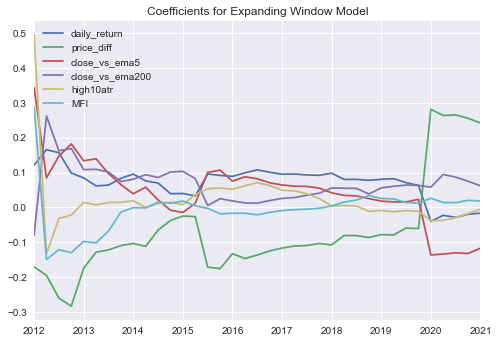

In [17]:
def build_coefs(models):
    coefs = pd.DataFrame()
    for i, model in enumerate(models):
        model_coefs = pd.Series(model.coef_[0],index=features_selected.columns.values)
        model_coefs.name = models.index[i]
        coefs = pd.concat([coefs,model_coefs],axis=1)
    return coefs.T

build_coefs(models).plot(title='Coefficients for Expanding Window Model')

The significance of coefficients vary as we include more data to train.


### Using Models

In [18]:
models_expanding_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    
    X_train = df_SPY.loc[:date, features_selected.columns]
    y_train = df_SPY['target_close_1'].loc[:date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models_expanding_window.loc[date] = model
    
models_rolling_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = df_SPY.loc[date-pd.Timedelta('90 days'):date, features_selected.columns]
    y_train = df_SPY['target_close_1'].loc[date-pd.Timedelta('90 days'):date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models_rolling_window.loc[date] = model
    
begin_dates = models.index[:-1]
end_dates = models.index[1:-1]
end_dates = end_dates.insert(item=df_SPY.index[-1], loc=len(end_dates)) 

predictions_expanding_window = pd.Series(index=features.index)
for i, model in enumerate(models_expanding_window.iloc[:-1]):
    X = df_SPY.loc[begin_dates[i]:end_dates[i]][features_selected.columns]
    X_scaled = standard_scaler.fit_transform(X)
    p = pd.Series(np.concatenate(model.predict(X_scaled)), index=X.index)
    predictions_expanding_window.loc[X.index] = p
    
predictions_rolling_window = pd.Series(index=features.index)
for i, model in enumerate(models_rolling_window.iloc[:-1]):
    X = df_SPY.loc[begin_dates[i]:end_dates[i]][features_selected.columns]
    X_scaled = standard_scaler.fit_transform(X)
    p = pd.Series(np.concatenate(model.predict(X_scaled)), index=X.index)
    predictions_rolling_window.loc[X.index] = p

<ipython-input-18-4d5a02d7f166>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  models_expanding_window = pd.Series(index=recalc_dates)
<ipython-input-18-4d5a02d7f166>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  models_rolling_window = pd.Series(index=recalc_dates)
<ipython-input-18-4d5a02d7f166>:33: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_expanding_window = pd.Series(index=features.index)
<ipython-input-18-4d5a02d7f166>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_

In [19]:
r2_expanding = r2_score(y_true=df_SPY.loc[predictions_expanding_window.dropna().index, 'target_close_1'], y_pred=predictions_expanding_window.dropna())
r2_rolling = r2_score(y_true=df_SPY.loc[predictions_rolling_window.dropna().index, 'target_close_1'], y_pred=predictions_rolling_window.dropna())

print("Expanding Window R2: {}".format(round(r2_expanding,3)))
print("Rolling Window R2: {}".format(round(r2_rolling,3)))

Expanding Window R2: -260.976
Rolling Window R2: -2164.581


## XGBoost Regressor

R2 test -0.43065133704272807


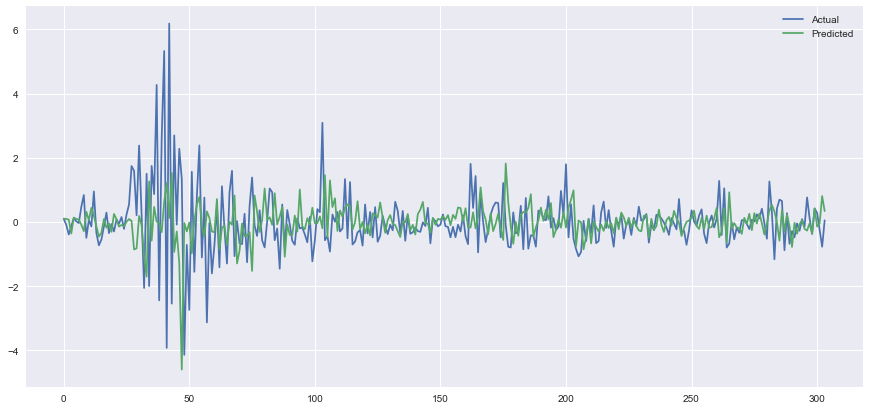

In [22]:
split_point = int(0.80*len(df))

train_dataset = features_selected.join(df_SPY['target_close_1']).iloc[:split_point,:]
standard_scaler.fit_transform(df_SPY)
X_train = train_dataset.iloc[:,:-1]
y_train = train_dataset['target_close_1']
X_test = features_selected.iloc[split_point:,:] 
y_test = df_SPY['target_close_1'].iloc[split_point:]

X_train = standard_scaler.fit_transform(X_train)
y_train = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
X_test = standard_scaler.fit_transform(X_test)
y_test = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))


xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

pred = xgb_model.predict(X_test)
print('R2 test {}'.format(r2_score(y_test, pred)))

plt.figure(figsize=(15,7))

plt.plot(y_test, label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

## Random Forest

<ipython-input-23-75a7114f2e67>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)


R2 test -0.15424194225396826


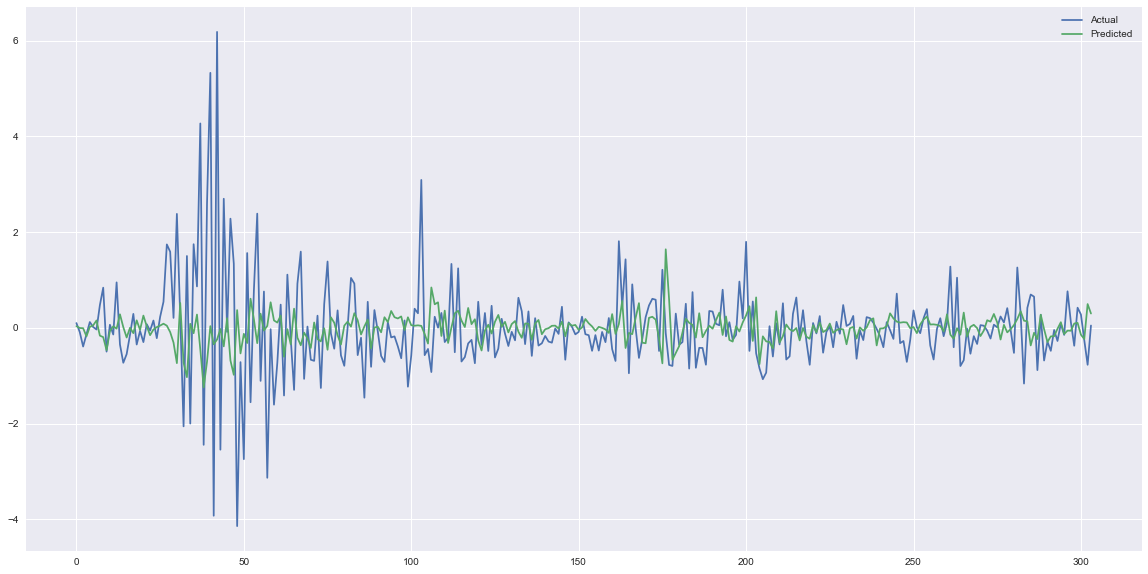

In [23]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

pred = regr.predict(X_test)
print('R2 test {}'.format(r2_score(y_test, pred)))

plt.figure(figsize=(20,10))

plt.plot(y_test, label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

# References

https://www.investopedia.com/terms/r/rsi.asp

https://www.investopedia.com/terms/m/macd.asp

https://altfins.com/knowledge-base/macd-line-and-macd-signal-line/

https://www.investopedia.com/terms/s/stochasticoscillator.asp

https://www.investopedia.com/terms/a/accumulationdistribution.asp

https://www.investopedia.com/terms/a/atr.asp

https://www.investopedia.com/articles/active-trading/072115/understand-vortex-indicator-trading-strategies.asp

https://www.investopedia.com/terms/e/easeofmovement.asp

https://www.investopedia.com/terms/c/commoditychannelindex.asp

https://www.investopedia.com/terms/o/onbalancevolume.asp

https://www.investopedia.com/terms/m/mfi.asp

https://www.investopedia.com/terms/l/lookaheadbias.asp

